In [1]:
#all the imports
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
#read path and filenames from json
import json
with open('private.json', 'r') as fp:
    data = json.load(fp)
    
#
path = data["path"]
chosen_csv = data["chosen-csv"]

In [3]:
#read the clean data
flies = pd.read_csv(path + chosen_csv, index_col = 0)

In [4]:
#flies.shape
flies.columns

Index(['conditioning', 'velmag', 'nflies_close', 'dcenter', 'Grooming',
       'Chase', 'anglesub', 'Chain', 'Aggregation'],
      dtype='object')

In [5]:
flies_dummies = pd.get_dummies(flies, prefix = '', prefix_sep = '')

In [6]:
flies_dummies.head()

,velmag,nflies_close,dcenter,Grooming,Chase,anglesub,Chain,Aggregation,Grouped,Grouped_Starved,Males_Grouped_and_Female,Mated,Rejected,Single
790,1.300277,-0.706385,1.134822,-0.890364,-0.299740,-0.746801,-0.670277,-0.802969,1,0,0,0,0,0
861,-0.638452,1.086899,-0.903284,-0.601865,-0.546524,0.845178,1.568521,1.214433,1,0,0,0,0,0
1864,-0.349844,0.272753,-0.320796,0.257870,-0.064735,1.577785,0.262814,0.298801,0,0,0,0,1,0
846,-0.597022,-0.339701,2.507975,1.074271,-0.616874,-0.687426,-0.044147,-0.376889,1,0,0,0,0,0
689,0.122566,-0.653870,0.656026,0.337420,-0.448242,-0.816920,-0.808162,-0.555081,1,0,0,0,0,0


In [7]:
def model_scatter(model, X_train, X_test, y_train, y_test, caption, ax):
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test  = sqrt(mean_squared_error(y_test, y_test_pred))

    r2_train = r2_score(y_train, y_train_pred)
    r2_test  = r2_score(y_test, y_test_pred)
    
    print(f"{caption}\n\trmse/r2 train =  {rmse_train:}/{r2_train}\n\trmse/r2 test =  {rmse_test}/{r2_test}")

    train = pd.DataFrame({"y" : y_train, "y_pred" : y_train_pred})
    train["label"] = f"train; rmse: {rmse_train:.3f}; r2: {r2_train:.3f}"

    test = pd.DataFrame({"y" : y_test, "y_pred" : y_test_pred})
    test["label"] = f"test;  rmse: {rmse_test:.3f}; r2: {r2_test:.3f}"
    
    df = pd.concat([train, test])
    sns.scatterplot(data = df, x = "y", y = "y_pred", hue = "label", ax = ax).set(title = caption)

In [8]:
def regression(score : str, trainsize : float= 0.7, dominant_count : int = 3, laso_alpha : float = 0.01, scatter_plot : bool = True):

    #start pipeline
    X = flies_dummies.drop([score], axis = 1)
    y = flies_dummies[score]

    #Splitting to Test/Train
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = trainsize, random_state = 0)

    #Testing with Lasso
    lasso = Lasso(alpha = laso_alpha).fit(X_train, y_train)
    abs_coef = np.abs(lasso.coef_)
    coef_index = np.argsort(abs_coef)
    print(f"Lasso |Coefs|:\n{abs_coef}\n{coef_index}")    
    
    #selecting only the dominant features
    keep_columns = set()
    for i in range(dominant_count):
        keep_columns.add(X_test.columns[coef_index[-i]])
    print(f"Selecting {dominant_count} Columns:\n{keep_columns}")
    drop_columns = set(X_test.columns.tolist()) - keep_columns
    #print(f"Dropping Columns:\n{drop_columns}")
    X_train = X_train.drop(drop_columns, axis = 1)
    X_test = X_test.drop(drop_columns, axis = 1)

    lr = LinearRegression().fit(X_train, y_train)    
    knr = KNeighborsRegressor(n_neighbors = dominant_count).fit(X_train, y_train)
    dtr = DecisionTreeRegressor().fit(X_train, y_train) #max_depth = dominant_count

    if scatter_plot:

        fig, ax = plt.subplots(3, 1, figsize = (20, 20))

        #Linear Regression Fitting
        model_scatter(lr, X_train, X_test, y_train, y_test, "Linear Regression", ax[0])        

        #KNN Fitting
        model_scatter(knr, X_train, X_test, y_train, y_test, "K Neighbors Regression", ax[1])

        #Descision tree
        model_scatter(dtr, X_train, X_test, y_train, y_test, "Decision Tree Regression", ax[2])
    
    return (lr, knr, dtr, list(keep_columns))

Lasso |Coefs|:
[0.75356172 0.02137677 0.08619855 0.00323519 0.         0.
 0.         0.02397471 0.         0.         0.29399671 0.
 0.        ]
[ 4  5  6  8  9 11 12  3  1  7  2 10  0]
Selecting 10 Columns:
{'nflies_close', 'velmag', 'Rejected', 'Males_Grouped_and_Female', 'Grouped', 'Mated', 'anglesub', 'dcenter', 'Single', 'Chase'}
Linear Regression
	rmse/r2 train =  0.5538973737366745/0.6957747300441741
	rmse/r2 test =  0.5446976845143773/0.697235467576195
K Neighbors Regression
	rmse/r2 train =  0.4832204009392383/0.7684593778548487
	rmse/r2 test =  0.5351663995646024/0.707738494778374
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  0.6554302650320577/0.5616238454754352


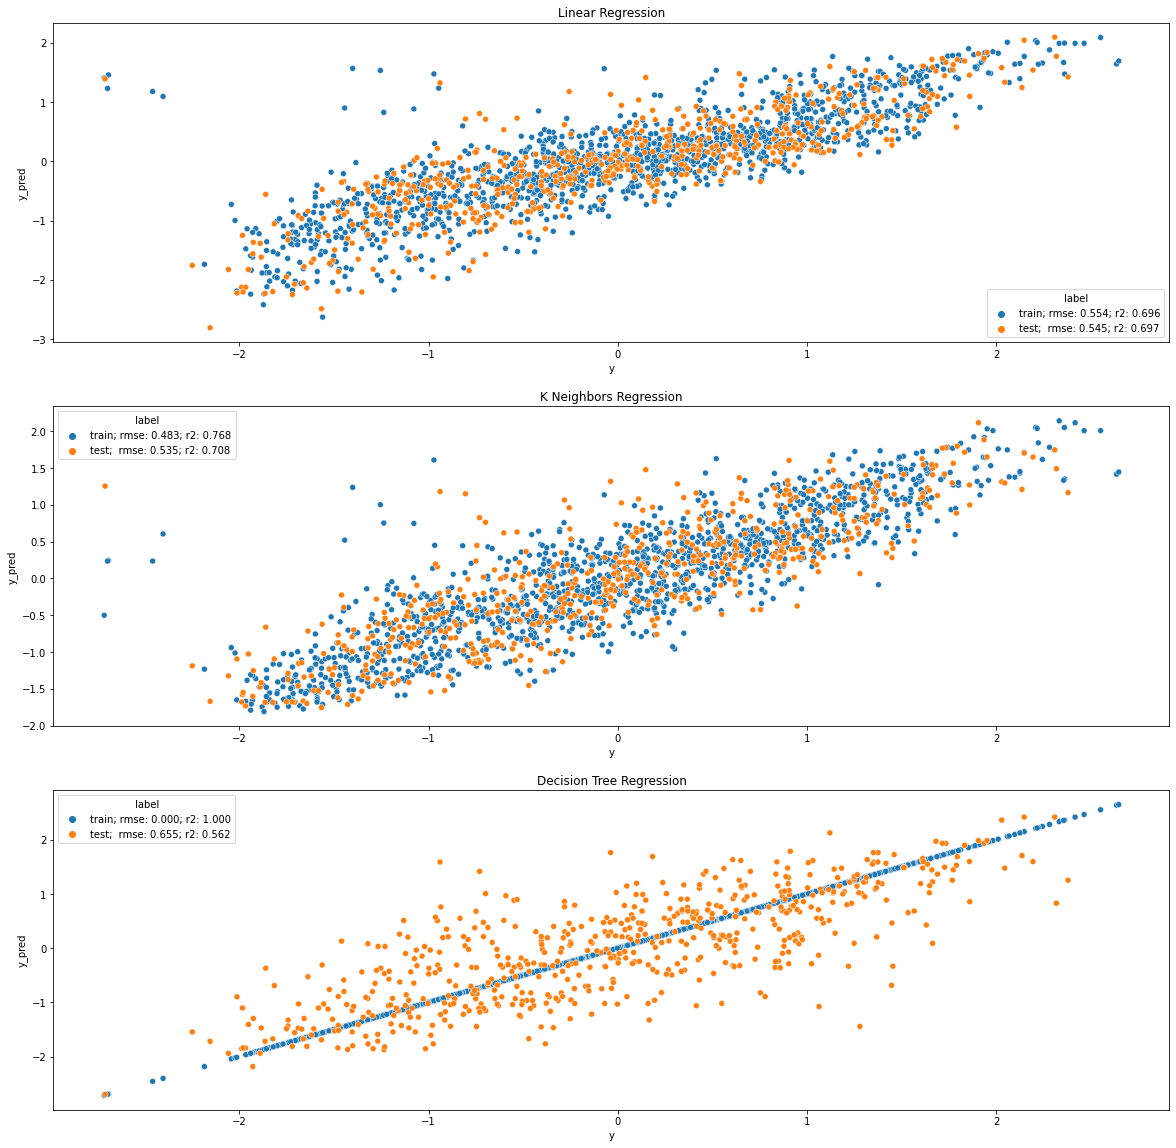

In [9]:
regression("Grooming", trainsize = 0.7, dominant_count = 10);

Lasso |Coefs|:
[0.46253079 0.37205234 0.23821868 0.02255058 0.28725047 0.56399584
 0.18849326 0.19997408 0.         0.         0.         0.0201351
 0.        ]
[ 8  9 10 12 11  3  6  7  2  4  1  0  5]
Selecting 7 Columns:
{'nflies_close', 'velmag', 'Grouped', 'Chain', 'anglesub', 'dcenter', 'Grouped_Starved'}
Linear Regression
	rmse/r2 train =  0.5898820795907461/0.650694941689707
	rmse/r2 test =  0.6315736573411364/0.6063740051470754
K Neighbors Regression
	rmse/r2 train =  0.43167352371570944/0.8129381202017864
	rmse/r2 test =  0.4079762076925898/0.8357499805311539
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  0.47322134950717026/0.7790141756554496


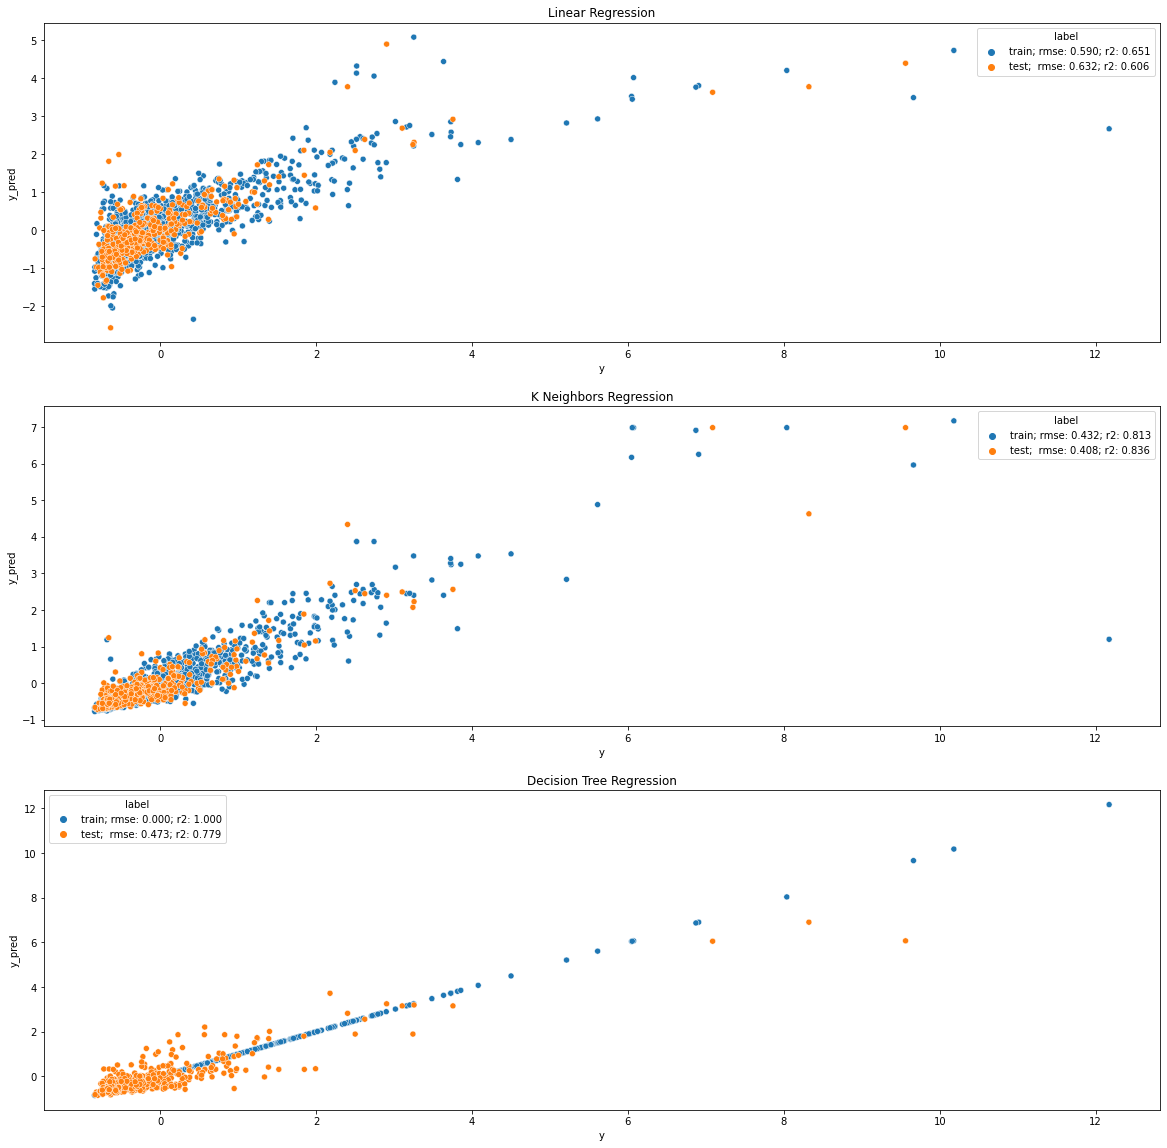

In [10]:
regression("Chase", trainsize = 0.8, dominant_count = 7);

Lasso |Coefs|:
[0.         0.74882234 0.06647054 0.         0.19234823 0.16580631
 0.         0.         0.         0.         0.         0.
 0.        ]
[ 0  3  6  7  8  9 10 11 12  2  5  4  1]
Selecting 4 Columns:
{'nflies_close', 'Chase', 'anglesub', 'velmag'}
Linear Regression
	rmse/r2 train =  0.334868288934316/0.8877999385378256
	rmse/r2 test =  0.3504904729322554/0.8775110573746631
K Neighbors Regression
	rmse/r2 train =  0.2699675385852449/0.9270763928954596
	rmse/r2 test =  0.35628821551515266/0.8734251659157037
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  0.5340173987059714/0.715648669539678


(LinearRegression(),
 KNeighborsRegressor(n_neighbors=4),
 DecisionTreeRegressor(),
 ['nflies_close', 'Chase', 'anglesub', 'velmag'])

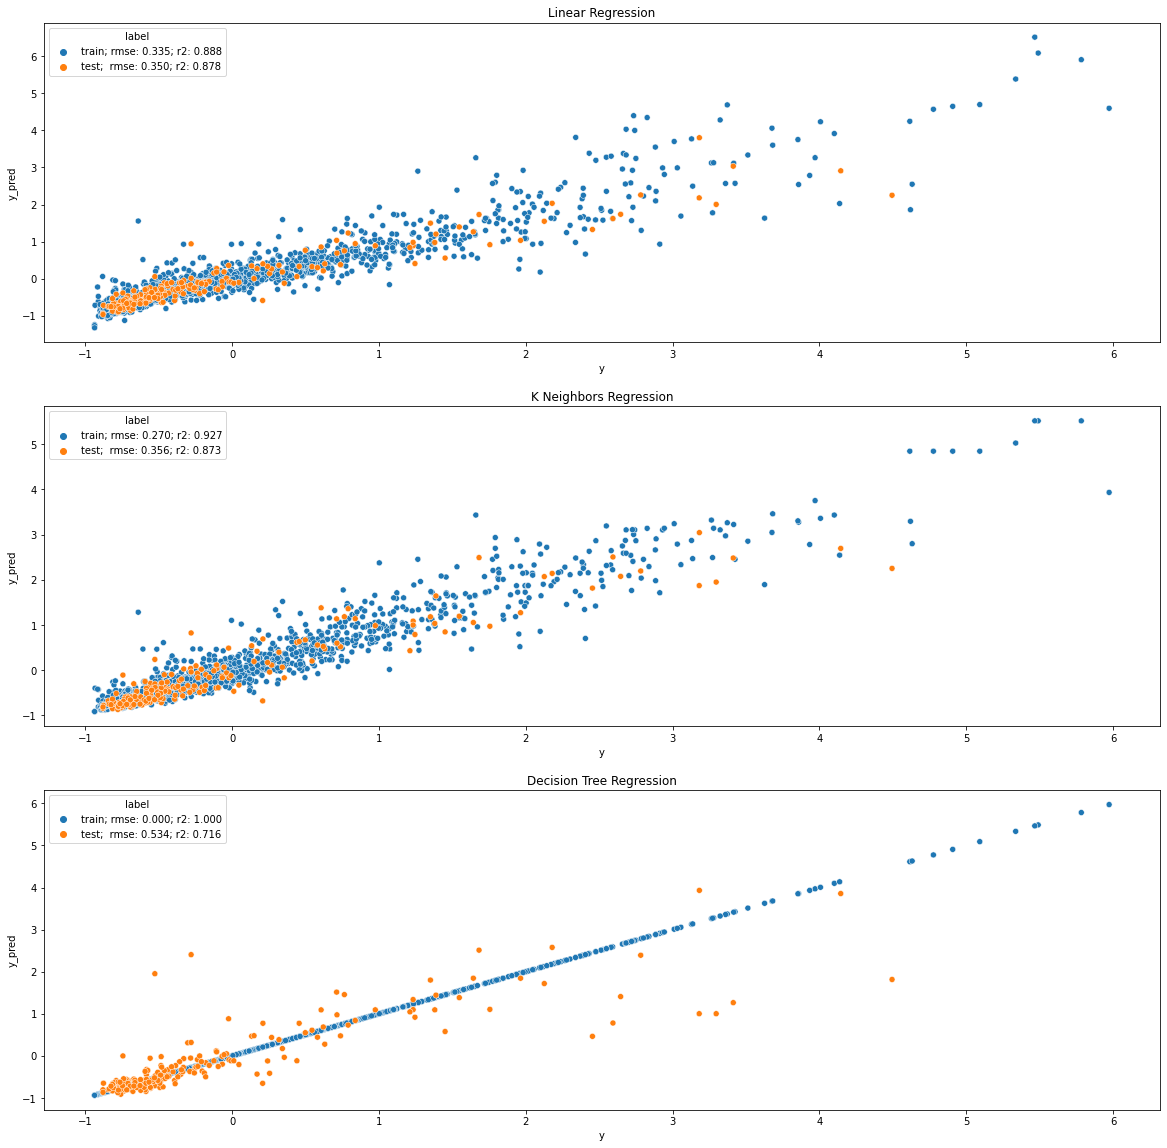

In [11]:
regression("Chain", trainsize = 0.9, dominant_count = 4)

Lasso |Coefs|:
[0.33821675 0.48679178 0.35726725 0.         0.09459578 0.20211764
 0.         0.         0.         0.         0.24273604 0.05061548
 0.04122373]
[ 3  6  7  8  9 12 11  4  5 10  0  2  1]
Selecting 3 Columns:
{'nflies_close', 'dcenter', 'Grooming'}
Linear Regression
	rmse/r2 train =  0.5299857683558612/0.7203339337869721
	rmse/r2 test =  0.4652956373861143/0.774487913803988
K Neighbors Regression
	rmse/r2 train =  0.2974005894503823/0.911936689370115
	rmse/r2 test =  0.4283023829009178/0.808921051512463
Decision Tree Regression
	rmse/r2 train =  0.0/1.0
	rmse/r2 test =  0.4986429845222843/0.741005054863364


(LinearRegression(),
 KNeighborsRegressor(n_neighbors=3),
 DecisionTreeRegressor(),
 ['nflies_close', 'dcenter', 'Grooming'])

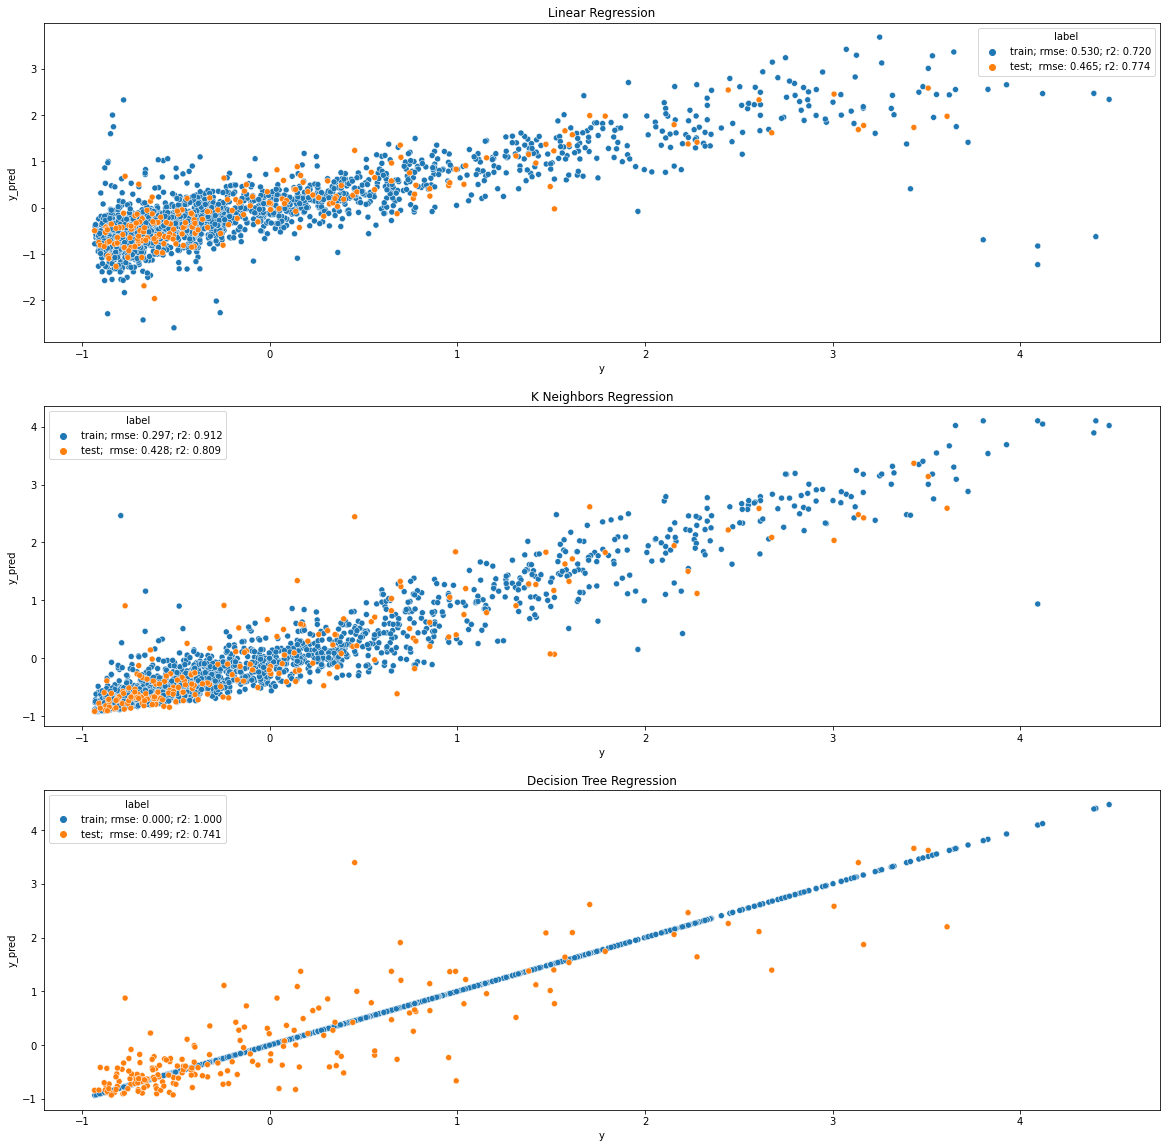

In [12]:
regression("Aggregation", trainsize = 0.9, dominant_count = 3)

Lasso |Coefs|:
[0.74729921 0.02429143 0.08705228 0.         0.         0.
 0.         0.00894053 0.         0.         0.2521992  0.
 0.        ]
[ 3  4  5  6  8  9 11 12  7  1  2 10  0]
Selecting 3 Columns:
{'Chase', 'Mated', 'velmag'}


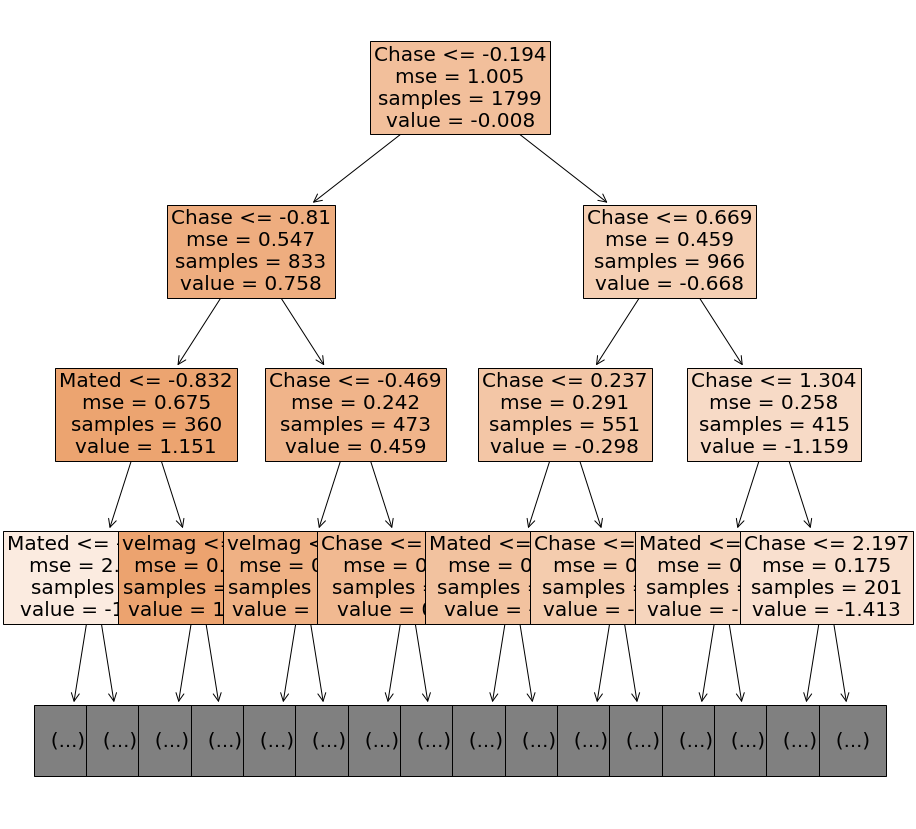

In [13]:
(lr, knr, dtr, features) = regression("Grooming", trainsize = 0.9, dominant_count = 3, scatter_plot = False)

#tree output that does not require graphviz
plt.figure(figsize = (15, 15))
tree.plot_tree(dtr, max_depth = 3, feature_names = features, filled = True, fontsize = 20);